# # Sentiment Analysis on Amazon Product Reviews
Goal: Predict Sentiment from review text.

Input: Review Text
Label: Positive(1), Negative (0)


This notebook follows a standard ML workflow:
1. Dataset overview & quality checks  
2. Text preprocessing  
3. Train/test split  
4. Baseline models (LogReg, Naive Bayes, Linear SVM)  
5. Evaluation (Accuracy, Precision, Recall, F1, Confusion Matrix)  
6. Hyperparameter tuning (GridSearchCV)  
7. Comparative analysis  
8. Imbalance-aware experiment and  conclusion

# Imports 

In [17]:

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, balanced_accuracy_score
)


# Dataset Overview

We verify:
- shape and column names
- missing values
- duplicates / empty strings
- class distribution (imbalance)

# Load data + initial checks 

In [18]:
df = pd.read_csv("amazon.csv")  

display(df.head())
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

print("\nMissing values:\n", df.isnull().sum())

print("\nDuplicate rows:", df.duplicated().sum())
print("Empty reviews:", (df["reviewText"].astype(str).str.strip() == "").sum())

print("\nLabel distribution (counts):\n", df["Positive"].value_counts())
print("\nLabel distribution (percent):\n", df["Positive"].value_counts(normalize=True).round(3))

,reviewText,Positive
0,This is a one of the best apps acording to a b...,1
1,This is a pretty good version of the game for ...,1
2,this is a really cool game. there are a bunch ...,1
3,"This is a silly game and can be frustrating, b...",1
4,This is a terrific game on any pad. Hrs of fun...,1


Shape: (20000, 2)
Columns: ['reviewText', 'Positive']

Missing values:
 reviewText    0
Positive      0
dtype: int64

Duplicate rows: 0
Empty reviews: 0

Label distribution (counts):
 Positive
1    15233
0     4767
Name: count, dtype: int64

Label distribution (percent):
 Positive
1    0.762
0    0.238
Name: proportion, dtype: float64


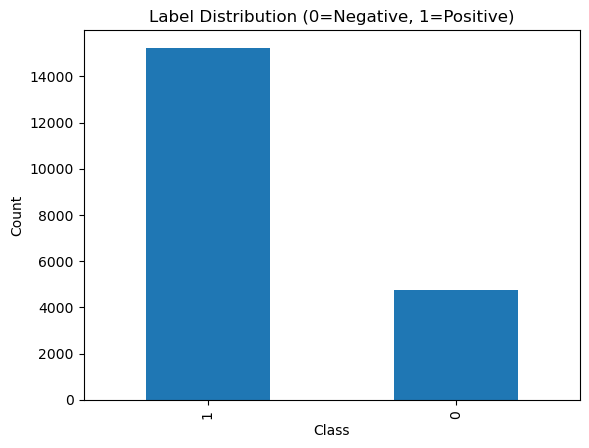

In [19]:
# Plot 

ax = df["Positive"].value_counts().plot(kind="bar")
ax.set_title("Label Distribution (0=Negative, 1=Positive)")
ax.set_xlabel("Class")
ax.set_ylabel("Count")
plt.show()

# Text Preprocessing

- lowercase
- remove non-letters (keep spaces)
- remove extra whitespace


In [20]:
df = df[["reviewText", "Positive"]].copy()
df["reviewText"] = df["reviewText"].astype(str)
df["Positive"] = df["Positive"].astype(int)

df["clean_review"] = (
    df["reviewText"]
    .str.lower()
    .str.replace(r"[^a-z\s]", " ", regex=True)   # keep letters/spaces only
    .str.replace(r"\s+", " ", regex=True)       # collapse whitespace
    .str.strip()
)

# remove any empty rows after cleaning (safety)
df = df[df["clean_review"] != ""].copy()

display(df[["reviewText", "clean_review", "Positive"]].head())
print("After cleaning shape:", df.shape)

,reviewText,clean_review,Positive
0,This is a one of the best apps acording to a b...,this is a one of the best apps acording to a b...,1
1,This is a pretty good version of the game for ...,this is a pretty good version of the game for ...,1
2,this is a really cool game. there are a bunch ...,this is a really cool game there are a bunch o...,1
3,"This is a silly game and can be frustrating, b...",this is a silly game and can be frustrating bu...,1
4,This is a terrific game on any pad. Hrs of fun...,this is a terrific game on any pad hrs of fun ...,1


After cleaning shape: (20000, 3)


#  Train/Test Split


In [24]:
X = df["clean_review"]
y = df["Positive"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", len(X_train), "| Test size:", len(X_test))
print("\nTrain distribution:\n", y_train.value_counts(normalize=True).round(3))
print("\nTest distribution:\n", y_test.value_counts(normalize=True).round(3))

Train size: 16000 | Test size: 4000

Train distribution:
 Positive
1    0.762
0    0.238
Name: proportion, dtype: float64

Test distribution:
 Positive
1    0.762
0    0.238
Name: proportion, dtype: float64


# Evaluation Helper

- Accuracy, Precision, Recall, F1
- Balanced Accuracy (useful for imbalanced data)
- Confusion Matrix
- **Precision:** when the model predicts positive, how often it is correct  
- **Recall:** how many actual positives the model correctly finds  
- **F1:** balances precision and recall (useful for imbalanced classes)
- **Balanced Accuracy:** average of recall over both classes (useful for imbalance)

In [25]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test, show_cm=True):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    metrics = {
        "Model": name,
        "Accuracy": accuracy_score(y_test, pred),
        "Precision": precision_score(y_test, pred, zero_division=0),
        "Recall": recall_score(y_test, pred, zero_division=0),
        "F1": f1_score(y_test, pred, zero_division=0),
        "Balanced_Accuracy": balanced_accuracy_score(y_test, pred)
    }

    print(f"\n=== {name} ===")
    for k in ["Accuracy", "Precision", "Recall", "F1", "Balanced_Accuracy"]:
        print(f"{k}: {metrics[k]:.4f}")

    print("\nClassification Report:\n", classification_report(y_test, pred, zero_division=0))

    if show_cm:
        cm = confusion_matrix(y_test, pred)
        plt.figure(figsize=(4, 3))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(f"Confusion Matrix - {name}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

    return metrics, model

# ## 6. Baseline Models (TF-IDF + Classifier) 
TF-IDF was used because it converts text into numeric features that work well with classical machine learning models, emphasizing informative words while down-weighting very common words.

We train and evaluate three standard models for text classification:
1) Logistic Regression  
2) Multinomial Naive Bayes  
3) Linear SVM (LinearSVC)


=== Logistic Regression (Baseline) ===
Accuracy: 0.9032
Precision: 0.9115
Recall: 0.9669
F1: 0.9384
Balanced_Accuracy: 0.8334

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.70      0.78       953
           1       0.91      0.97      0.94      3047

    accuracy                           0.90      4000
   macro avg       0.89      0.83      0.86      4000
weighted avg       0.90      0.90      0.90      4000



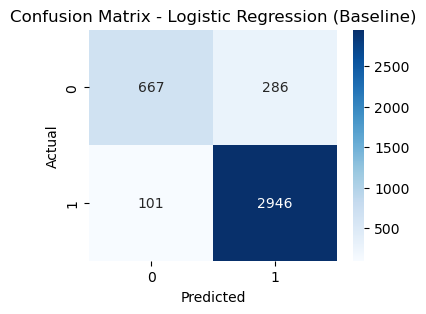


=== Naive Bayes (Baseline) ===
Accuracy: 0.8575
Precision: 0.8494
Recall: 0.9882
F1: 0.9135
Balanced_Accuracy: 0.7139

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.44      0.60       953
           1       0.85      0.99      0.91      3047

    accuracy                           0.86      4000
   macro avg       0.89      0.71      0.75      4000
weighted avg       0.87      0.86      0.84      4000



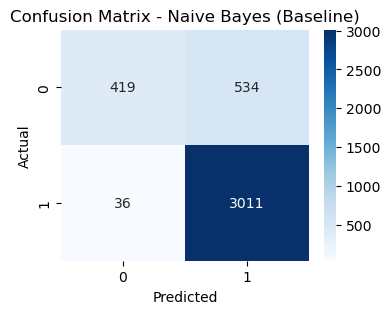


=== Linear SVM (Baseline) ===
Accuracy: 0.9030
Precision: 0.9271
Recall: 0.9472
F1: 0.9370
Balanced_Accuracy: 0.8545

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.76      0.79       953
           1       0.93      0.95      0.94      3047

    accuracy                           0.90      4000
   macro avg       0.87      0.85      0.86      4000
weighted avg       0.90      0.90      0.90      4000



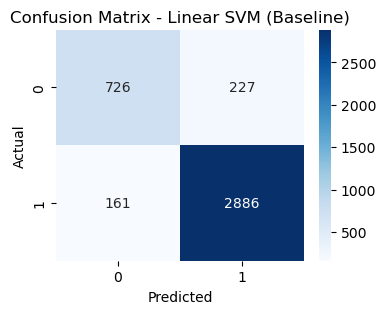

,Model,Accuracy,Precision,Recall,F1,Balanced_Accuracy
0,Logistic Regression (Baseline),0.90325,0.911510,0.966853,0.938366,0.833374
2,Linear SVM (Baseline),0.90300,0.927080,0.947161,0.937013,0.854483
1,Naive Bayes (Baseline),0.85750,0.849365,0.988185,0.913532,0.713925


In [26]:
baseline_models = {
    "Logistic Regression (Baseline)": Pipeline([
        ("tfidf", TfidfVectorizer(max_features=5000)),
        ("clf", LogisticRegression(max_iter=1000))
    ]),
    "Naive Bayes (Baseline)": Pipeline([
        ("tfidf", TfidfVectorizer(max_features=5000)),
        ("clf", MultinomialNB())
    ]),
    "Linear SVM (Baseline)": Pipeline([
        ("tfidf", TfidfVectorizer(max_features=5000)),
        ("clf", LinearSVC())
    ]),
}

baseline_results = []
trained_baselines = {}

for name, mdl in baseline_models.items():
    m, fitted = evaluate_model(name, mdl, X_train, y_train, X_test, y_test)
    baseline_results.append(m)
    trained_baselines[name] = fitted

baseline_df = pd.DataFrame(baseline_results).sort_values(by="F1", ascending=False)
baseline_df


## 7. Hyperparameter Tuning (Grid Search)
We tune the two best-performing families:
- Logistic Regression
- Linear SVM

We tune:
- TF-IDF max_features
- TF-IDF ngram_range (unigrams vs bigrams)
- C (regularization strength)

Best LR params: {'clf__C': 10, 'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 2)}
Best LR CV F1: 0.9421083060097337

=== Logistic Regression (Tuned) ===
Accuracy: 0.9150
Precision: 0.9312
Recall: 0.9593
F1: 0.9450
Balanced_Accuracy: 0.8663

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.77      0.81       953
           1       0.93      0.96      0.95      3047

    accuracy                           0.92      4000
   macro avg       0.89      0.87      0.88      4000
weighted avg       0.91      0.92      0.91      4000



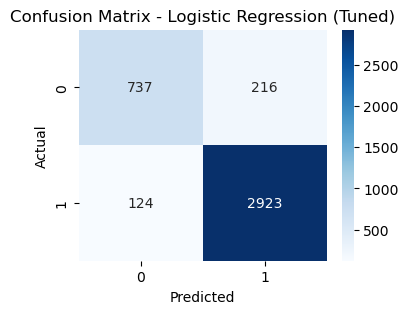

In [28]:
# Tune Logistic Regression

lr_pipe = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", LogisticRegression(max_iter=1000))
])

lr_grid = {
    "tfidf__max_features": [3000, 5000, 10000],
    "tfidf__ngram_range": [(1, 1), (1, 2)],
    "clf__C": [0.1, 1, 10]
}

lr_search = GridSearchCV(lr_pipe, lr_grid, cv=3, scoring="f1", n_jobs=-1)
lr_search.fit(X_train, y_train)

print("Best LR params:", lr_search.best_params_)
print("Best LR CV F1:", lr_search.best_score_)

best_lr = lr_search.best_estimator_
lr_tuned_metrics, _ = evaluate_model("Logistic Regression (Tuned)", best_lr, X_train, y_train, X_test, y_test)


Best SVM params: {'clf__C': 1, 'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 2)}
Best SVM CV F1: 0.942071715551465

=== Linear SVM (Tuned) ===
Accuracy: 0.9150
Precision: 0.9328
Recall: 0.9573
F1: 0.9449
Balanced_Accuracy: 0.8685

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.78      0.81       953
           1       0.93      0.96      0.94      3047

    accuracy                           0.92      4000
   macro avg       0.89      0.87      0.88      4000
weighted avg       0.91      0.92      0.91      4000



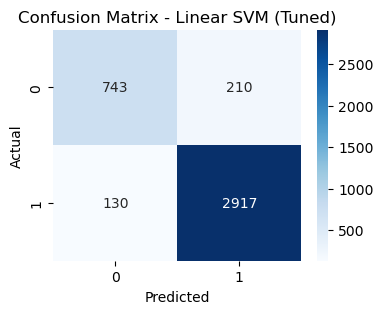

In [29]:
# Tune Linear SVM

svm_pipe = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", LinearSVC())
])

svm_grid = {
    "tfidf__max_features": [3000, 5000, 10000],
    "tfidf__ngram_range": [(1, 1), (1, 2)],
    "clf__C": [0.1, 1, 10]
}

svm_search = GridSearchCV(svm_pipe, svm_grid, cv=3, scoring="f1", n_jobs=-1)
svm_search.fit(X_train, y_train)

print("Best SVM params:", svm_search.best_params_)
print("Best SVM CV F1:", svm_search.best_score_)

best_svm = svm_search.best_estimator_
svm_tuned_metrics, _ = evaluate_model("Linear SVM (Tuned)", best_svm, X_train, y_train, X_test, y_test)

# Final Comparison Table + Plot
Comparative Analysis

Compare baseline vs tuned models using a single table and a bar chart.

Primary metric: F1-score (robust for imbalance).

In [30]:
final_rows = baseline_results + [lr_tuned_metrics, svm_tuned_metrics]
final_df = pd.DataFrame(final_rows).sort_values(by="F1", ascending=False)
final_df

,Model,Accuracy,Precision,Recall,F1,Balanced_Accuracy
3,Logistic Regression (Tuned),0.91500,0.931188,0.959304,0.945037,0.866326
4,Linear SVM (Tuned),0.91500,0.932843,0.957335,0.944930,0.868489
0,Logistic Regression (Baseline),0.90325,0.911510,0.966853,0.938366,0.833374
2,Linear SVM (Baseline),0.90300,0.927080,0.947161,0.937013,0.854483
1,Naive Bayes (Baseline),0.85750,0.849365,0.988185,0.913532,0.713925


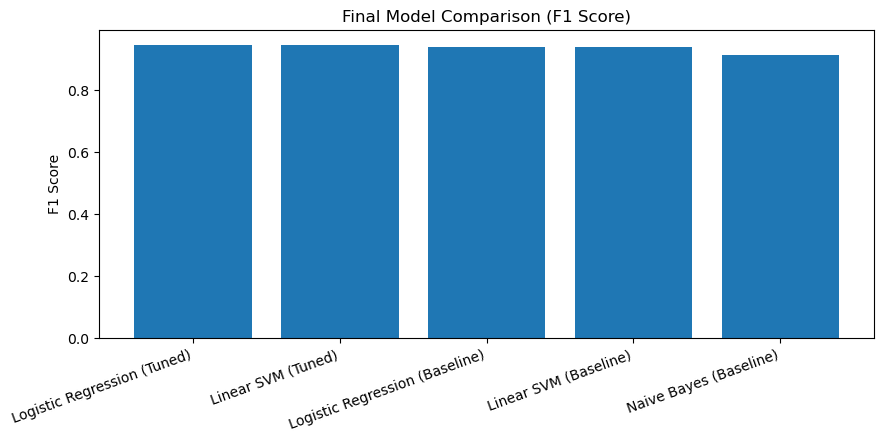

In [31]:
plt.figure(figsize=(10, 4))
plt.bar(final_df["Model"], final_df["F1"])
plt.title("Final Model Comparison (F1 Score)")
plt.ylabel("F1 Score")
plt.xticks(rotation=20, ha="right")
plt.show()

## 9. Imbalance-Aware Experiment (Class Weighting)
Because the dataset is imbalanced, we test whether class weighting improves detection of the minority class (negative reviews).
We keep the dataset unchanged and adjust training using `class_weight="balanced"`.


=== Logistic Regression (Balanced) ===
Accuracy: 0.9173
Precision: 0.9548
Recall: 0.9357
F1: 0.9451
Balanced_Accuracy: 0.8970

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.86      0.83       953
           1       0.95      0.94      0.95      3047

    accuracy                           0.92      4000
   macro avg       0.88      0.90      0.89      4000
weighted avg       0.92      0.92      0.92      4000



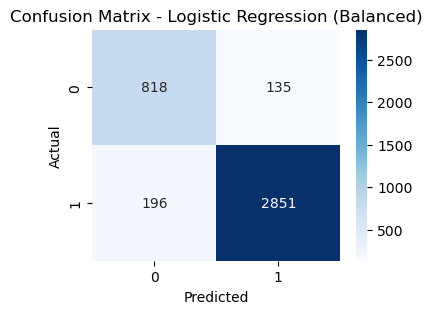

,Model,Accuracy,Precision,Recall,F1,Balanced_Accuracy
5,Logistic Regression (Balanced),0.91725,0.954789,0.935674,0.945135,0.897008
3,Logistic Regression (Tuned),0.91500,0.931188,0.959304,0.945037,0.866326
4,Linear SVM (Tuned),0.91500,0.932843,0.957335,0.944930,0.868489
0,Logistic Regression (Baseline),0.90325,0.911510,0.966853,0.938366,0.833374
2,Linear SVM (Baseline),0.90300,0.927080,0.947161,0.937013,0.854483
1,Naive Bayes (Baseline),0.85750,0.849365,0.988185,0.913532,0.713925


In [32]:

lr_bal = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
    ("clf", LogisticRegression(max_iter=1000, C=10, class_weight="balanced"))
])

lr_bal_metrics, _ = evaluate_model("Logistic Regression (Balanced)", lr_bal, X_train, y_train, X_test, y_test)

final_df2 = pd.DataFrame(final_rows + [lr_bal_metrics]).sort_values(by="F1", ascending=False)
final_df2

# Lemmatization


In [1]:
import nltk

def ensure_nltk_resource(path, package_name):
    try:
        nltk.data.find(path)
    except LookupError:
        nltk.download(package_name, quiet=True)

ensure_nltk_resource("corpora/wordnet", "wordnet")
ensure_nltk_resource("corpora/omw-1.4", "omw-1.4")

In [35]:
from sklearn.model_selection import train_test_split

y = df["Positive"]

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    df["clean_review"], y, test_size=0.2, random_state=42, stratify=y
)

X_train_lem, X_test_lem, _, _ = train_test_split(
    df["clean_review_lem"], y, test_size=0.2, random_state=42, stratify=y
)

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report

def train_eval_lr(X_train, X_test, y_train, y_test, name):
    model = Pipeline([
        ("tfidf", TfidfVectorizer(max_features=10000, ngram_range=(1,2))),
        ("clf", LogisticRegression(max_iter=1000, C=10))
    ])
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)

    print(f"\n=== {name} ===")
    print("Accuracy:", round(acc, 4))
    print("F1:", round(f1, 4))
    print(classification_report(y_test, pred, zero_division=0))

    return acc, f1

acc_raw, f1_raw = train_eval_lr(X_train_raw, X_test_raw, y_train, y_test, "No Lemmatization")
acc_lem, f1_lem = train_eval_lr(X_train_lem, X_test_lem, y_train, y_test, "With Lemmatization")


=== No Lemmatization ===
Accuracy: 0.915
F1: 0.945
              precision    recall  f1-score   support

           0       0.86      0.77      0.81       953
           1       0.93      0.96      0.95      3047

    accuracy                           0.92      4000
   macro avg       0.89      0.87      0.88      4000
weighted avg       0.91      0.92      0.91      4000


=== With Lemmatization ===
Accuracy: 0.9167
F1: 0.9463
              precision    recall  f1-score   support

           0       0.86      0.77      0.82       953
           1       0.93      0.96      0.95      3047

    accuracy                           0.92      4000
   macro avg       0.90      0.87      0.88      4000
weighted avg       0.92      0.92      0.92      4000



In [38]:
compare_df = pd.DataFrame([
    {"Preprocessing": "No Lemmatization", "Accuracy": acc_raw, "F1": f1_raw},
    {"Preprocessing": "With Lemmatization", "Accuracy": acc_lem, "F1": f1_lem},
]).sort_values(by="F1", ascending=False)

print(compare_df)

        Preprocessing  Accuracy        F1
1  With Lemmatization   0.91675  0.946264
0    No Lemmatization   0.91500  0.945037


In [40]:
# Using lemmatization slightly improved results compared to the non-lemmatized pipeline (F1: 0.9450 → 0.9463; Accuracy: 0.9150 → 0.9167).
# Minority-class (negative) F1 also improved slightly (0.81 → 0.82), indicating a small benefit for detecting negative reviews.

# Conclusion 



**Summary:**
- Baseline models showed that Logistic Regression and Linear SVM perform similarly and outperform Naive Bayes.
- Hyperparameter tuning improved performance by using TF-IDF bigrams and a larger feature vocabulary.
- Due to class imbalance, we also tested a class-weighted Logistic Regression model to improve minority class recall.

**Final model choice:**
- Choose the tuned model with the best F1-score for overall performance.
- If catching negative reviews is the priority, prefer the class-weighted model if it improves class-0 recall.

**Limitations:**
- Text-only approach may struggle with sarcasm, very short reviews, or ambiguous language.
- Additional data or richer models (embeddings/neural models) could further improve performance.